In [3]:
import pandas as pd
import ast
import os
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd

load_dotenv()
API_KEY = os.getenv('API_KEY')

df = pd.read_csv('triplets.csv')
cause = df['cause'].to_list()
effect = df['effect']

pool = set(cause + effect)

In [4]:
embedding = {}

openai_key = ""
from openai import OpenAI
client = OpenAI(api_key=API_KEY)

def get_embedding(text, model="text-embedding-3-large"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding


In [8]:
import concurrent.futures
from typing import Set, Dict, Any

def process_item(item: str) -> tuple[str, Any]:
    print(f"Processing item: {item}")
    embedding = get_embedding(item)
    return (item, embedding)

def get_concurrent_embeddings(kw_set: Set[str], max_workers: int = 5) -> Dict[str, Any]:
    embeddings = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_item = {
            executor.submit(process_item, item): item 
            for item in kw_set
        }
        
        for future in concurrent.futures.as_completed(future_to_item):
            try:
                item, embedding = future.result()
                embeddings[item] = embedding
            except Exception as e:
                print(f"Error processing {future_to_item[future]}: {str(e)}")
    
    return embeddings

embedding = get_concurrent_embeddings(pool)

Processing item: AI interaction guidelines enhance user experience when adhered to during optimal AI performance.
Processing item: AI systems provoke deep reflections by engaging users in evaluative processes.
Processing item: AI systems create indirect communities by celebrating user goals and behaviors.
Processing item: Explainable AI facilitates trust by providing human-level explanations and can be processed affectively.
Processing item: Information presentation beyond explanations moderates trust formation during human-AI interactions.
Processing item: AI products adhering to HAI guidelines are generally more inclusive of diverse problem-solving styles.
Processing item: AI products offering more user control tend to be more inclusive.
Processing item: AI products' inclusivity is influenced by whether they learn from individual or collective data.
Processing item: The AI music application prototypes exhibit distinct user control levels in intermittent, continuous, and proactive int

Optimal number of clusters: 11


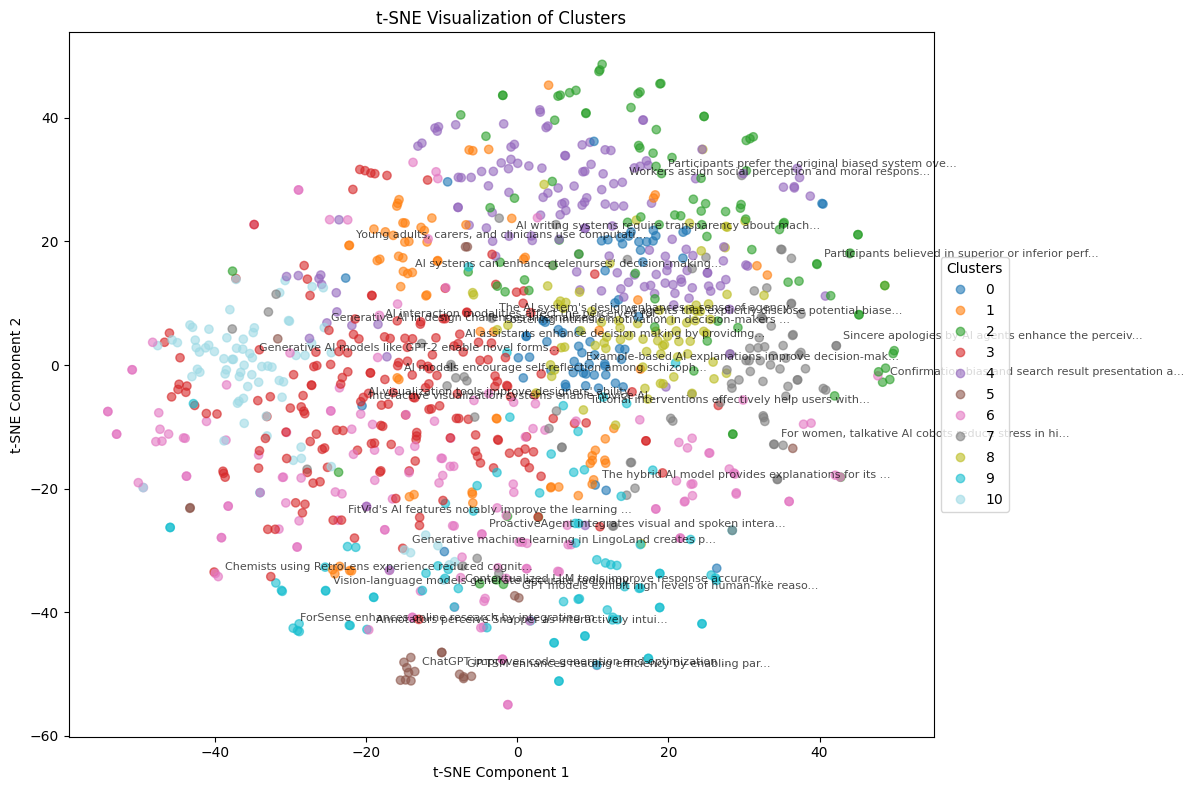


Cluster Statistics:
--------------------------------------------------

Cluster 0:
Number of statements: 66
Sample statements:
- Explainable AI facilitates trust by providing human-level explanations and can be processed affectiv...
- End-users prefer XAI explanations that provide practical, actionable information over technical syst...
- Part-based XAI explanations, resembling human reasoning, are favored by end-users....

Cluster 1:
Number of statements: 73
Sample statements:
- Designers of AI platforms in healthcare demonstrate system effectiveness one metric at a time, leadi...
- AI-enhanced pervasive sensing platforms create breakdowns in patient journeys by focusing on either ...
- AI decision support systems with interactive forward reasoning improve management of output uncertai...

Cluster 2:
Number of statements: 98
Sample statements:
- Self-voice alarms elicit higher alertness and uncomfortable feelings compared to beep sound alarms....
- Safety drivers face limited self-de

[nltk_data] Downloading package punkt to /Users/chayapatr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chayapatr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/chayapatr/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [25]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from kneed import KneeLocator
from typing import Dict, List, Tuple
import seaborn as sns

def determine_optimal_k(embeddings: np.ndarray, max_k: int = 20) -> int:
    """
    Determine optimal number of clusters using elbow method
    
    Args:
        embeddings: numpy array of embeddings
        max_k: maximum number of clusters to try
    
    Returns:
        optimal number of clusters
    """
    inertias = []
    k_values = range(1, max_k + 1)
    
    # Calculate inertia for different k values
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)
    
    # Use knee locator to find the optimal k
    kneedle = KneeLocator(
        k_values, 
        inertias, 
        S=1.0, 
        curve="convex", 
        direction="decreasing"
    )
    
    # If no clear elbow is found, use square root of n/2
    if kneedle.elbow is None:
        optimal_k = int(np.sqrt(len(embeddings) / 2))
    else:
        optimal_k = kneedle.elbow
        
    return optimal_k

def perform_clustering(embedding_dict: Dict[str, List[float]]) -> Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering on embeddings
    
    Args:
        embedding_dict: dictionary mapping statements to their embeddings
    
    Returns:
        tuple of (reduced embeddings, cluster labels, statements)
    """
    # Convert dictionary to arrays
    statements = list(embedding_dict.keys())
    embeddings = np.array([embedding_dict[stmt] for stmt in statements])
    
    # Determine optimal number of clusters
    optimal_k = determine_optimal_k(embeddings)
    print(f"Optimal number of clusters: {optimal_k}")
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    return reduced_embeddings, cluster_labels, statements

def visualize_clusters(reduced_embeddings: np.ndarray, 
                      cluster_labels: np.ndarray, 
                      statements: list,
                      figsize: tuple = (12, 8)) -> None:
    """
    Visualize clusters using scatter plot
    
    Args:
        reduced_embeddings: t-SNE reduced embeddings
        cluster_labels: cluster assignments
        statements: original statements
        figsize: figure size
    """
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=cluster_labels,
        cmap='tab20',
        alpha=0.6
    )
    
    # Add legend
    legend1 = plt.legend(*scatter.legend_elements(),
                        title="Clusters",
                        loc="center left",
                        bbox_to_anchor=(1, 0.5))
    # plt.addartist(legend1)
    
    # Add labels and title
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    # Add annotations for a few points from each cluster
    unique_clusters = np.unique(cluster_labels)
    for cluster in unique_clusters:
        # Get indices for current cluster
        cluster_idx = np.where(cluster_labels == cluster)[0]
        # Sample up to 3 points from cluster
        sample_idx = np.random.choice(cluster_idx, 
                                    size=min(3, len(cluster_idx)), 
                                    replace=False)
        
        for idx in sample_idx:
            plt.annotate(statements[idx][:50] + '...' if len(statements[idx]) > 50 else statements[idx],
                        (reduced_embeddings[idx, 0], reduced_embeddings[idx, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Example usage
# Replace this with your actual embedding dictionary
example_dict = {
    "statement1": [0.1, 0.2, 0.3],
    "statement2": [0.2, 0.3, 0.4],
    # ... more statements and embeddings
}

# Perform clustering and visualization
reduced_emb, labels, stmts = perform_clustering(embedding)
visualize_clusters(reduced_emb, labels, stmts)

# Additional Analysis: Cluster Statistics
def analyze_clusters(statements: list, cluster_labels: np.ndarray) -> None:
    """
    Print statistics about the clusters
    """
    unique_clusters = np.unique(cluster_labels)
    print("\nCluster Statistics:")
    print("-" * 50)
    
    for cluster in unique_clusters:
        cluster_statements = [stmt for i, stmt in enumerate(statements) 
                            if cluster_labels[i] == cluster]
        print(f"\nCluster {cluster}:")
        print(f"Number of statements: {len(cluster_statements)}")
        print("Sample statements:")
        for stmt in cluster_statements[:3]:  # Show first 3 statements
            print(f"- {stmt[:100]}...")
            
# Run cluster analysis
analyze_clusters(stmts, labels)

# Save results to CSV
def analyze_cluster_content(statements: list, 
                        embeddings: np.ndarray,
                        cluster_labels: np.ndarray,
                        kmeans_model: KMeans,
                        n_keywords: int = 10,
                        n_samples: int = 10) -> Dict[int, dict]:
    """
    Analyze and explain the content of each cluster
    
    Args:
        statements: list of original statements
        embeddings: original embeddings array
        cluster_labels: cluster assignments
        kmeans_model: fitted KMeans model
        n_keywords: number of keywords to extract per cluster
        n_samples: number of representative samples to show
        
    Returns:
        Dictionary containing analysis for each cluster
    """
    from sklearn.feature_extraction.text import TfidfVectorizer
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')
    
    # Initialize stop words
    stop_words = set(stopwords.words('english'))
    
    cluster_analysis = {}
    unique_clusters = np.unique(cluster_labels)
    
    for cluster in unique_clusters:
        # Get cluster-specific data
        cluster_mask = cluster_labels == cluster
        cluster_statements = np.array(statements)[cluster_mask]
        cluster_embeddings = embeddings[cluster_mask]
        
        # Calculate distances to cluster centroid
        centroid = kmeans_model.cluster_centers_[cluster]
        distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
        
        # Get representative samples (closest to centroid)
        closest_indices = np.argsort(distances)[:n_samples]
        representative_samples = cluster_statements[closest_indices]
        
        # Extract keywords using TF-IDF
        vectorizer = TfidfVectorizer(
            stop_words='english',
            max_features=n_keywords,
            ngram_range=(1, 2)
        )
        
        # Combine statements for better keyword extraction
        combined_text = ' '.join(cluster_statements)
        
        # Basic text preprocessing
        tokens = word_tokenize(combined_text.lower())
        tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
        processed_text = ' '.join(tokens)
        
        # Get TF-IDF scores
        try:
            tfidf_matrix = vectorizer.fit_transform([processed_text])
            feature_names = vectorizer.get_feature_names_out()
            scores = tfidf_matrix.toarray()[0]
            keywords = [feature_names[i] for i in scores.argsort()[-n_keywords:][::-1]]
        except ValueError:
            keywords = []
        
        # Calculate basic statistics
        avg_length = np.mean([len(stmt.split()) for stmt in cluster_statements])
        
        # Store analysis results
        cluster_analysis[cluster] = {
            'size': len(cluster_statements),
            'keywords': keywords,
            'representative_samples': representative_samples.tolist(),
            'avg_statement_length': avg_length,
            'coherence_score': -np.mean(distances)  # Higher score = more coherent
        }
    
    return cluster_analysis

def explain_clusters(cluster_analysis: Dict[int, dict], 
                    min_similarity_threshold: float = 0.5) -> None:
    """
    Print human-readable explanations of cluster characteristics
    
    Args:
        cluster_analysis: output from analyze_cluster_content
        min_similarity_threshold: threshold for considering clusters similar
    """
    print("Cluster Analysis Report")
    print("=" * 50)
    
    # Sort clusters by size
    sorted_clusters = sorted(cluster_analysis.items(), 
                           key=lambda x: x[1]['size'], 
                           reverse=True)
    
    for cluster_id, analysis in sorted_clusters:
        print(f"\nCluster {cluster_id} Analysis")
        print("-" * 30)
        
        # Basic statistics
        print(f"Size: {analysis['size']} statements")
        # print(f"Average statement length: {analysis['avg_statement_length']:.1f} words")
        # print(f"Coherence score: {analysis['coherence_score']:.3f}")
        
        # # Keywords
        # print("\nKey themes and phrases:")
        # for keyword in analysis['keywords']:
        #     print(f"  • {keyword}")
        
        # Representative samples
        print("\nRepresentative examples:")
        for i, sample in enumerate(analysis['representative_samples'], 1):
            if len(sample) > 100:
                sample = sample
            print(f"{i}. {sample}")
        
        # print("\nInterpretation:")
        # # Generate interpretation based on keywords and samples
        # if analysis['coherence_score'] > min_similarity_threshold:
        #     print("This is a highly coherent cluster with clear common themes.")
        # else:
        #     print("This cluster shows more diversity in its content.")
        
        # # Additional insights based on statistics
        # if analysis['avg_statement_length'] > 50:
        #     print("Statements in this cluster tend to be longer and more detailed.")
        # elif analysis['avg_statement_length'] < 20:
        #     print("Statements in this cluster are typically brief and concise.")
        
        print("-" * 50)

def save_results(statements: list, 
                cluster_labels: np.ndarray, 
                reduced_embeddings: np.ndarray,
                cluster_analysis: Dict[int, dict],
                filename: str = 'clustering_results.csv') -> None:
    """
    Save clustering results to CSV file
    """
    results_df = pd.DataFrame({
        'statement': statements,
        'cluster': cluster_labels,
        'tsne_1': reduced_embeddings[:, 0],
        'tsne_2': reduced_embeddings[:, 1]
    })
    
    # Add cluster analysis information
    results_df['cluster_size'] = results_df['cluster'].map(
        lambda x: cluster_analysis[x]['size'])
    results_df['cluster_keywords'] = results_df['cluster'].map(
        lambda x: ', '.join(cluster_analysis[x]['keywords']))
    results_df['cluster_coherence'] = results_df['cluster'].map(
        lambda x: cluster_analysis[x]['coherence_score'])
    
    results_df.to_csv(filename, index=False)
    print(f"\nResults saved to {filename}")

# Perform clustering and analysis
reduced_emb, labels, stmts = perform_clustering(embedding)
embeddings = np.array([embedding[stmt] for stmt in stmts])

# Get the KMeans model
optimal_k = determine_optimal_k(embeddings)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(embeddings)

# Analyze clusters
cluster_analysis = analyze_cluster_content(
    statements=stmts,
    embeddings=embeddings,
    cluster_labels=labels,
    kmeans_model=kmeans
)

# Print cluster explanations
explain_clusters(cluster_analysis)

# Save the results with cluster analysis
save_results(stmts, labels, reduced_emb, cluster_analysis)